![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
# Ignorar alertas
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Uso de GPU (Local)
import torch                                                                   # Librería principal de PyTorch
from torch import cuda                                                         # Librería para trabajar con GPU
USE_GPU = torch.cuda.is_available()                                            # Actidar uso de GPU

# Importación librerías
import os                                                                      # Librería para interactuar con el sistema operativo
import pandas as pd                                                            # Librería para manipulación de datos
import matplotlib.pyplot as plt                                                # Librería para visualización de datos
import seaborn as sns                                                          # Librería para visualización de datos
import numpy as np                                                             # Librería para manipulación de arrays y matrices

from sklearn.model_selection import train_test_split                           # División de datos en entrenamiento y prueba
from sklearn.feature_extraction.text import CountVectorizer                    # Vectorización de texto
from sklearn.preprocessing import MultiLabelBinarizer                          # Binarización de etiquetas múltiples
from sklearn.multiclass import OneVsRestClassifier                             # Vectorización de etiquetas múltiples
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier     # Modelos de bosque aleatorio
from sklearn.linear_model import LogisticRegression                            # Regresión logística
from sklearn.metrics import r2_score, roc_auc_score                            # Métricas de evaluación

import torch.nn as nn                                                          # Redes neuronales
import torch.optim as optim                                                    # Optimizadores de PyTorch
from torch.utils.data import DataLoader, TensorDataset                         # Cargador de datos de PyTorch

In [11]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [16]:
from transformers import BertTokenizer, BertModel
import torch

# Modelo preentrenado base (hay más como DistilBERT si quieres mayor velocidad)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [17]:
def get_bert_embedding(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        outputs = bert_model(**inputs)
        last_hidden_state = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Promediar sobre la dimensión de secuencia (tokens)
        embedding = last_hidden_state.mean(dim=1)  # [batch_size, hidden_size]
        return embedding.squeeze().numpy()  # [hidden_size]


In [18]:
from tqdm import tqdm
tqdm.pandas()

In [19]:
# Aplicar a los datos
dataTraining['plot_clean_bert'] = dataTraining['plot'].apply(get_bert_embedding)
dataTesting['plot_clean_bert'] = dataTesting['plot'].apply(get_bert_embedding)

## Modelo de red Neuronal

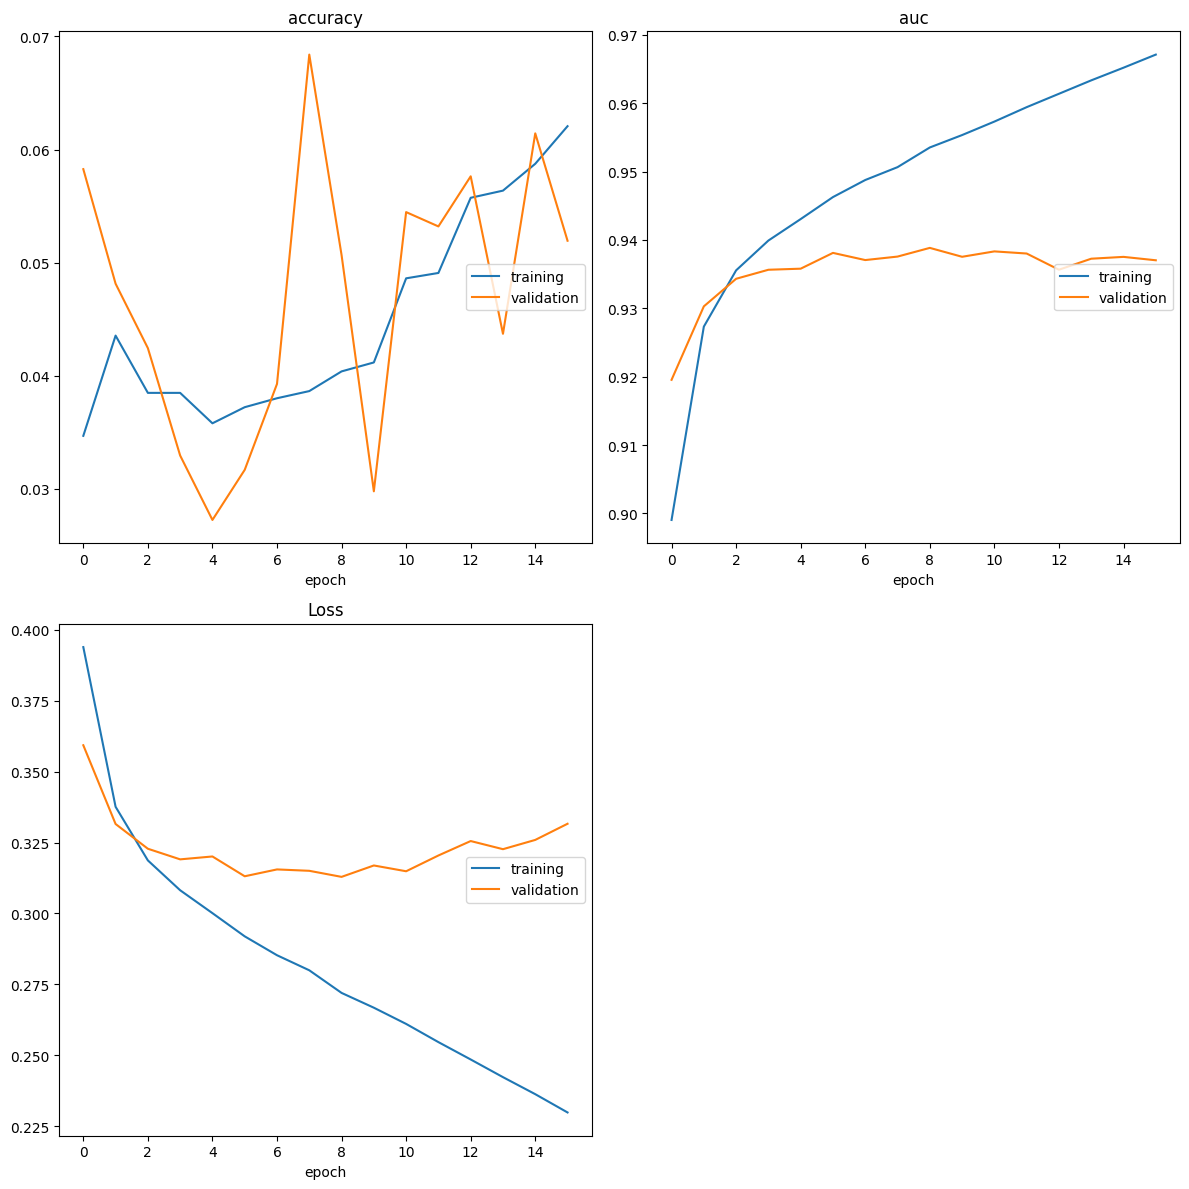

accuracy
	training         	 (min:    0.035, max:    0.062, cur:    0.062)
	validation       	 (min:    0.027, max:    0.068, cur:    0.052)
auc
	training         	 (min:    0.899, max:    0.967, cur:    0.967)
	validation       	 (min:    0.920, max:    0.939, cur:    0.937)
Loss
	training         	 (min:    0.230, max:    0.394, cur:    0.230)
	validation       	 (min:    0.313, max:    0.359, cur:    0.332)
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0631 - auc: 0.9667 - loss: 0.2316 - val_accuracy: 0.0519 - val_auc: 0.9370 - val_loss: 0.3316

Evaluación en conjunto de validación:
Loss: 0.3129, Accuracy: 0.0507, AUC: 0.9388
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step


Modelo guardado como bert_classifier_model.h5


In [22]:
# Definición de dimensiones de salida (variables de interés)
output_var = y_train.shape[1]
print(output_var, 'output variables')

# Definición de dimensiones de entrada (variables predictoras)
dims = X_train.shape[1]
print(dims, 'input variables')

# Importación librerías
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras
import tensorflow as tf

# Configuración de GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU disponible y configurada")
else:
    print("No se encontró GPU, usando CPU")

# Definición de función que crea la red neuronal
def nn_model_params(optimizer='adam',
                   neurons=128,
                   batch_size=32,
                   epochs=50,
                   activation='relu',
                   patience=5,
                   loss='binary_crossentropy'):
    
    K.clear_session()

    model = Sequential()
    
    # Capa de entrada y primera capa oculta
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    # Segunda capa oculta
    model.add(Dense(neurons, activation=activation))
    # Capa de salida (usamos sigmoid para clasificación multi-etiqueta)
    model.add(Dense(output_var, activation='sigmoid'))

    # Compilación del modelo
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy', metrics.AUC(name='auc')])
    
    # Early Stopping
    early_stopping = EarlyStopping(monitor="val_loss",
                                 patience=patience,
                                 restore_best_weights=True)

    # Entrenamiento del modelo
    history = model.fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[early_stopping, PlotLossesKeras()],
                       verbose=1)
    
    return model, history

# Parámetros del modelo
params = {
    'optimizer': Adam(learning_rate=0.001),
    'neurons': 256,  # Aumentado para manejar embeddings BERT
    'batch_size': 32,
    'epochs': 50,
    'activation': 'relu',
    'patience': 7,  # Paciencia mayor para embeddings profundos
    'loss': 'binary_crossentropy'
}

# Entrenamiento del modelo
model, history = nn_model_params(**params)

# Evaluación del modelo
print("\nEvaluación en conjunto de validación:")
val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

# Predicción en el conjunto de prueba
y_pred_test = model.predict(np.vstack(dataTesting['plot_clean_bert'].values))

# Guardar el modelo
model.save('bert_classifier_model.h5')
print("Modelo guardado como bert_classifier_model.h5")

## Aplicación del modelo a datos de test

In [ ]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres_spacy, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF_spacy_A.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,1.475685e-02,9.216788e-03,6.815847e-03,1.770008e-02,0.156444,0.940082,0.047585,0.136956,5.456854e-02,2.193326e-04,...,0.003908,0.175445,0.000511,0.008633,0.480635,5.231228e-03,0.001876,0.098285,4.087837e-04,0.001650
4,1.437802e-01,1.231633e-02,4.835258e-02,3.062820e-02,0.948124,0.134831,0.004285,0.704562,1.171409e-02,5.057353e-02,...,0.006370,0.006258,0.001620,0.226593,0.008736,4.153474e-02,0.000782,0.121490,6.805384e-03,0.007547
5,7.303308e-07,3.073784e-09,1.932690e-08,4.766587e-08,0.636783,0.222472,0.000005,0.904802,6.176697e-11,7.969936e-11,...,0.138072,0.000605,0.000049,0.361436,0.000492,1.773128e-07,0.000081,0.001052,4.999911e-09,0.000079
6,2.033373e-03,8.833767e-06,2.608019e-04,2.519774e-02,0.292231,0.149704,0.073378,0.958170,2.282881e-04,5.495205e-06,...,0.000074,0.056298,0.000171,0.145629,0.000203,4.428391e-04,0.000222,0.088209,7.259285e-05,0.000600
7,6.469489e-02,4.146942e-03,4.833041e-05,1.297155e-04,0.986143,0.000973,0.000072,0.687224,1.105086e-03,5.239716e-02,...,0.196999,0.000524,0.000168,0.999919,0.029094,3.563689e-04,0.151126,0.000578,3.300634e-03,0.013307


In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres_bert, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_LR_bert_A.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.002880,0.001415,0.006392,0.001445,0.048909,0.021057,0.000423,0.815335,0.009100,0.040963,...,0.015295,0.332824,0.000136,0.974528,0.001934,0.005550,0.000214,0.191476,0.000252,0.003422
4,0.178649,0.022792,0.000151,0.119641,0.144636,0.613284,0.207107,0.928546,0.000151,0.000025,...,0.000348,0.002937,0.000402,0.071667,0.000091,0.000051,0.000637,0.169286,0.002066,0.000008
5,0.031786,0.007278,0.001416,0.104238,0.068122,0.802877,0.003077,0.871554,0.001878,0.004576,...,0.000468,0.186329,0.000426,0.061844,0.008828,0.000079,0.002670,0.756754,0.005598,0.002419
6,0.244176,0.203218,0.002258,0.003097,0.164755,0.026905,0.000125,0.508542,0.002719,0.033578,...,0.006613,0.013053,0.000178,0.300089,0.027548,0.000461,0.005552,0.391181,0.170288,0.001221
7,0.004637,0.005760,0.000978,0.006916,0.102700,0.077982,0.000603,0.157001,0.011980,0.021181,...,0.008327,0.147497,0.000044,0.215837,0.701167,0.004158,0.000890,0.386829,0.000784,0.000143


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.base import BaseEstimator

# Custom wrapper class for Keras model
class KerasClassifierWrapper(BaseEstimator):
    def __init__(self, optimizer='adam', neurons=128, batch_size=32, 
                 activation='relu', epochs=50):
        self.optimizer = optimizer
        self.neurons = neurons
        self.batch_size = batch_size
        self.activation = activation
        self.epochs = epochs
        self.model_ = None
        
    def _create_model(self):
        model = Sequential()
        model.add(Dense(self.neurons, input_shape=(dims,), activation=self.activation))
        model.add(Dense(self.neurons, activation=self.activation))
        model.add(Dense(output_var, activation='sigmoid'))
        
        model.compile(optimizer=self.optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
        return model
    
    def fit(self, X, y, **kwargs):
        tf.keras.backend.clear_session()
        self.model_ = self._create_model()
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # If validation data is provided
        validation_data = kwargs.get('validation_data', None)
        
        history = self.model_.fit(X, y,
                                batch_size=self.batch_size,
                                epochs=self.epochs,
                                validation_data=validation_data,
                                callbacks=[early_stopping],
                                verbose=1)
        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
    def score(self, X, y):
        _, _, auc = self.model_.evaluate(X, y, verbose=0)
        return auc  # Using AUC as scoring metric

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU will be used for training")
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
else:
    print("No GPU available, using CPU")

# Define parameter grid for GridSearch
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'neurons': [128, 256],
    'batch_size': [32, 64],
    'activation': ['relu', 'tanh'],
}

# Create and run GridSearchCV
model = KerasClassifierWrapper()
grid = GridSearchCV(estimator=model,
                  param_grid=param_grid,
                  cv=3,
                  scoring='roc_auc',
                  n_jobs=1,
                  verbose=2)

# Combine train and validation for proper cross-validation
X_full = np.concatenate((X_train, X_val))
y_full = np.concatenate((y_train, y_val))

grid_result = grid.fit(X_full, y_full)

# Show results
print("\nBest parameters found: ", grid_result.best_params_)
print("Best AUC score: ", grid_result.best_score_)

# Train best model with full training data
best_params = grid_result.best_params_
best_model = KerasClassifierWrapper(**best_params)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val))

# Evaluate on validation set
val_auc = best_model.score(X_val, y_val)
print(f"\nValidation set AUC: {val_auc:.4f}")

# Make predictions on test set
y_pred_test = best_model.predict(np.vstack(dataTesting['plot_clean_bert'].values))
